# SAMPLE NOTEBOOK
* To test out models and hyperparameter tuning

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# train_test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Validation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

## Load Data

In [3]:
df = pd.read_csv('CLEANDATA/clean_data_N2.csv', index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882247 entries, 0 to 882246
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   LIGHTING_CONDITION         882247 non-null  object
 1   CRASH_TYPE                 882247 non-null  object
 2   DAMAGE                     882247 non-null  object
 3   NUM_UNITS                  882247 non-null  int64 
 4   MOST_SEVERE_INJURY         882247 non-null  object
 5   CRASH_HOUR                 882247 non-null  int64 
 6   CRASH_DAY_OF_WEEK          882247 non-null  int64 
 7   CRASH_MONTH                882247 non-null  int64 
 8   SEC_CONTRIBUTORY_CAUSE_N   882247 non-null  object
 9   PRIM_CONTRIBUTORY_CAUSE_N  882247 non-null  object
 10  TRAFFICWAY_TYPE_N          882247 non-null  object
 11  ROAD_DEFECT_N              882247 non-null  object
 12  ROADWAY_SURFACE_COND_N     882247 non-null  object
 13  FIRST_CRASH_TYPE_N         882247 non-null  

## Create sample to work with

In [4]:
sample_df = df.sample(n=80000, random_state=1)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 597559 to 370995
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   LIGHTING_CONDITION         80000 non-null  object
 1   CRASH_TYPE                 80000 non-null  object
 2   DAMAGE                     80000 non-null  object
 3   NUM_UNITS                  80000 non-null  int64 
 4   MOST_SEVERE_INJURY         80000 non-null  object
 5   CRASH_HOUR                 80000 non-null  int64 
 6   CRASH_DAY_OF_WEEK          80000 non-null  int64 
 7   CRASH_MONTH                80000 non-null  int64 
 8   SEC_CONTRIBUTORY_CAUSE_N   80000 non-null  object
 9   PRIM_CONTRIBUTORY_CAUSE_N  80000 non-null  object
 10  TRAFFICWAY_TYPE_N          80000 non-null  object
 11  ROAD_DEFECT_N              80000 non-null  object
 12  ROADWAY_SURFACE_COND_N     80000 non-null  object
 13  FIRST_CRASH_TYPE_N         80000 non-null  object
 14  WEATH

## Work

### Train-test split

In [5]:
X = sample_df.drop('DAMAGE', axis=1)
y = sample_df['DAMAGE']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((56000, 16), (24000, 16))

### preprogress

In [7]:
encoder = OneHotEncoder(handle_unknown='ignore')
SS = StandardScaler(with_mean=False)

In [8]:
# encode

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [9]:
# Standardize

X_train_SS = SS.fit_transform(X_train_encoded)
X_test_SS = SS.transform(X_test_encoded)

## Model

### Hypertuning

#### LogisticRegression

In [10]:
# Best C 

C_list = [1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
cv_scores = []
cv_scores_std = []

for c in C_list:
    logreg = LogisticRegression(C = c) # using default lbfgs solver
    cv_loop_results = cross_validate(
                X=X_train_SS, 
                y=y_train,
                estimator=logreg, 
                cv=8)
    cv_scores.append(np.mean(np.sqrt(np.abs(cv_loop_results['test_score']))))
    cv_scores_std.append(np.std(np.sqrt(np.abs(cv_loop_results['test_score']))))

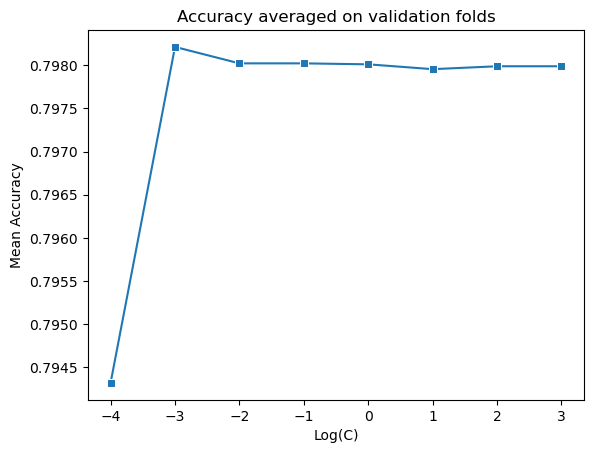

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x = np.log10(C_list), y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Log(C)')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy averaged on validation folds')
plt.show()

In [12]:
cv_scores

[0.7943212312377638,
 0.7982117037307886,
 0.7980213332544696,
 0.7980213547559025,
 0.7980101621480609,
 0.7979541749786162,
 0.7979877994493192,
 0.7979877994493192]

In [13]:
cv_scores_std

[0.0004584499445337868,
 0.0009660072716375785,
 0.0011123781032341329,
 0.0010968444920579936,
 0.001099854469541098,
 0.0011302616240680124,
 0.0010891353209818188,
 0.0010891353209818188]

------------------------

In [14]:
# Best L1 or L2

model_LR = LogisticRegression(solver='liblinear', max_iter=10000)

In [15]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # 'saga' supports both L1 and L2
}

In [16]:
grid_search = GridSearchCV(estimator=model_LR, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

In [17]:
grid_search.fit(X_train_SS, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [18]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.6376071428571428


-------------------------

In [19]:
# ROC_AUC

# y_probs = model_LR.predict(X_test_SS)[:, 1]
# roc_auc = roc_auc_score(y_test, y_probs)

In [20]:
# Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# roc_auc = auc(fpr, tpr)

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid()
# plt.show()

#### DecisionTree

In [21]:
model_DT = DecisionTreeClassifier()

In [22]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [23]:
grid_search = GridSearchCV(estimator=model_DT, param_grid=param_grid,scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

In [24]:
grid_search.fit(X_train_SS, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_pa

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [25]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score: 0.6324464285714286


### KNN

In [26]:
model_KNN = KNeighborsClassifier()

In [27]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
}

In [28]:
grid_search = GridSearchCV(estimator=model_KNN, param_grid=param_grid,scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

In [29]:
grid_search.fit(X_train_SS, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/mylearnenv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/en

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [3, 5, 7, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [30]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
Best Score: 0.6084107142857142
